In [1]:
using Pkg
Pkg.activate(".")

#using CUDA
using BenchmarkTools
using FFTW
using LoopVectorization
using Plots
using FastChebInterp
using Tullio

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`
[ Info: Precompiling LoopVectorization [bdcacae8-1622-11e9-2a5c-532679323890]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
Precompiling IJuliaExt
  ✓ XSLT_jll
  ✓ Plots → FileIOExt
  ✓ Plots → UnitfulExt
  ✓ Plots → IJuliaExt
  4 dependencies successfully precompiled in 63 seconds. 167 already precompiled.
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
┌ Warning: Module Plots with build ID fafbfcfd-5197-7179-000a-bdfbf4c1135a is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a].
[ Info: Precompiling FastChebInterp [cf66c380-9a80-432c-aff8-4f9c79c0bdde]
Precompiling StaticArrayInterfaceStaticArraysExt
  ✓ StaticArrayInterface → S

# Less is more: an approximation theory perspective on cosmological angular statistics computation

In this notebook we are gonn benchmark several of the components required to compute the $C_\ell$ without the Limber approximation in a new way, where we use insights from approximation theory.

The integral we wanna compute is

$$
C^{AB}_{ij}(\ell)=4 \pi \int_0^{\infty} d \chi_1 W^A_i\left(\chi_1\right) \int_0^{\infty} d \chi_2 W^B_j\left(\chi_2\right)\int_0^{\infty} d k \,P(k,\chi_1,\chi_2) j_{\ell}\left(k \chi_1\right)j_{\ell}\left(k \chi_2\right)
$$

## First step: the inner double Bessel integral

The first integral we wanna compute is the inner integral with the two Bessel functions

$$
w(\ell,\,\chi_1,\,\chi_2)=\int_0^{\infty} d k \,P(k,\chi_1,\chi_2) j_{\ell}\left(k \chi_1\right)j_{\ell}\left(k \chi_2\right)
$$

The idea is similar to the FFTLog of [Schonber et al., 2018](https://arxiv.org/abs/1807.09540), but with some important differences.
We are gonna decompose the Power Spectrum on the Chebyshev Polynomial Basis

$$
P(k,\chi_1,\chi_2) = \sum_{n=0}^{N_\mathrm{max}}c_n(\chi_1, \chi_2)T_n(k)
$$

where $T_n$ is the $n$-th Chebyshev polynomial.
The key fact here is that Chebyshev polynomial are, in fact, polynomials and we can compute integrals like the one we are interested in an analytical way
$$
I_{\ell}(\nu, t) \equiv 4 \pi \int_0^{\infty} \frac{d u}{u} u^\nu j_{\ell}(u) j_{\ell}(u t)=\frac{2^{\nu-1} \pi^2 \Gamma\left(\ell+\frac{\nu}{2}\right)}{\Gamma\left(\frac{3-\nu}{2}\right) \Gamma\left(\ell+\frac{3}{2}\right)} t_2^{\ell}{ }_2 F_1\left(\frac{\nu-1}{2}, \ell+\frac{\nu}{2} ; \ell+\frac{3}{2} \mid t^2\right)
$$
where $\Gamma$ is the Gamma function and ${ }_2 F_1$ is a confluent hypergeometric function (hope for you you never saw it while studying Physics on Landau Textbooks).
Nils's paper spent quite a decent amount of time to evaluate the ${ }_2 F_1$. However, we are gonna take advantage of some stable Julia implementations, such as [ArbNumerics.jl](https://github.com/JeffreySarnoff/ArbNumerics.jl). However, this is not going to be a minor details: we are gonna compute it only once!

But let's benchmark something: the Chebyshev coefficients can be computed by means of an FFT. Here we are gonna take advantage of the Julia wrapper of FFTW.
If we use an expansion with $n-1$ coefficients, we are gonna to apply an FFT to an array with $n$ elements. Preliminary tests, show that $n=164$ gives $0.01\%$ up to $k_\mathrm{max}=1.0\,\mathrm{Mpc}^{-1}$. In order to reach $k_\mathrm{max}=10.0\,\mathrm{Mpc}^{-1}$, $256$ coefficients are needed.
The second important thing is the number of redshift combination we are gonna use to compute the final integrals.
Given what was done:
- for the N5K challenge by the matter entry (see this [config file](https://github.com/LSSTDESC/N5K/blob/master/tests/config_matter_chi02.yml))
- the [TwoFast.jl algorithm](https://arxiv.org/abs/1709.02401)
- the [Angpow algorith](https://arxiv.org/abs/1701.03592)
 
considering $139$ points in $z$ should be a reasonable choice. This means we are going to compute $\frac{139\cdot140}{2}$ FFTs. Let's go!

### Non mi è super chiaro il numero di FFT :( 

Questo primo benchmark è per la scomposizione di P(k, $\chi_1$, $\chi_2$) sulla base dei Cheb

In [3]:
n_k = 128 # Perchè non 256?
n_z1=150 #numero di punti in chi_1 e 2 rispettivamente 
n_z2=75
n_z1_z2 = Int(n_z1*n_z2)
n_l = 18 #numero di multipoli (l values)
n_tomo1 = 10 #combinazioni tomografiche (indici i e j)
n_tomo2 = 5 #replicano il numero di bin in N5K


x = rand(n_z1_z2, n_k) #FFT per i coefficienti di Cheb in direzione k 
FFTW.set_num_threads(1) # c'è una trasformata per ogni punto sulla griglia-> quindi sono 150*75*128 no?
y = FFTW.plan_r2r(x, FFTW.DHT, [2]) #operazioni once for all salvate (2 è l'asse lungo cui trasformare) operatore trasformata 
b1 = @benchmark $y*$x #benchmark è una macro di julia + sintassi per FFT--> applico l'operatore trasformata a x!
#i dollari sono sintassi del benchmark, meglio metterli ma non fondamentali 

BenchmarkTools.Trial: 1294 samples with 1 evaluation.
 Range (min … max):  3.472 ms …   5.971 ms  ┊ GC (min … max): 0.00% … 15.80%
 Time  (median):     3.723 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.851 ms ± 365.201 μs  ┊ GC (mean ± σ):  3.72% ±  6.45%

   ▂▇█▆▂    ▁                                                  
  ▆█████▆▆▆▆█▇▆▆▆▄▄▅▄▃▂▃▃▃▃▃▁▃▃▄▆▇▅▄▄▃▃▃▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  3.47 ms         Histogram: frequency by time        4.96 ms <

 Memory estimate: 10.99 MiB, allocs estimate: 2.

    GC: julia è garbage collected. La memoria è gestita automaticamente, cancella variabili inutili. Più è basso meglio è, sto ottimizzando la memoria. 
    DHT: discrete Hartley transform

In [4]:
FFTW.set_num_threads(2)
y = FFTW.plan_r2r(x, FFTW.DHT, [2])
b2 = @benchmark $y*$x

BenchmarkTools.Trial: 2096 samples with 1 evaluation.
 Range (min … max):  1.978 ms …  11.808 ms  ┊ GC (min … max): 0.00% …  0.00%
 Time  (median):     2.118 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.374 ms ± 628.772 μs  ┊ GC (mean ± σ):  6.92% ± 10.68%

  ▅██▆▄▄▃▁        ▂▄▄▃▂▁  ▁                                   ▁
  ███████████▇▆▇▄████████▇█▇▅▆▇▄▆▆▄▆▄▁▄▁▁▁▄▁▆▁▄▁▄▁▄▁▄▁▄▄▁▄▁▄▄ █
  1.98 ms      Histogram: log(frequency) by time      4.99 ms <

 Memory estimate: 10.99 MiB, allocs estimate: 26.

In [5]:
FFTW.set_num_threads(4)
y = FFTW.plan_r2r(x, FFTW.DHT, [2])
b3 = @benchmark $y*$x

BenchmarkTools.Trial: 3138 samples with 1 evaluation.
 Range (min … max):  1.114 ms …  10.475 ms  ┊ GC (min … max):  0.00% … 83.29%
 Time  (median):     1.268 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   1.583 ms ± 533.812 μs  ┊ GC (mean ± σ):  10.52% ± 14.25%

  ▇█▅▅▄▂▂            ▄▄▄▄▃▂▁ ▁▁▃▃▄▄▂             ▁▁ ▁         ▁
  █████████▆▆▇▆▅▆▄▆██████████████████▇▆▄▄▅▆▅▄▅▅▇▆██▇██▇▆▆▆▄▅▅ █
  1.11 ms      Histogram: log(frequency) by time      2.98 ms <

 Memory estimate: 10.99 MiB, allocs estimate: 38.

In [6]:
FFTW.set_num_threads(8)
y = FFTW.plan_r2r(x, FFTW.DHT, [2])
b4 = @benchmark $y*$x

BenchmarkTools.Trial: 2863 samples with 1 evaluation.
 Range (min … max):  1.129 ms …  11.828 ms  ┊ GC (min … max): 0.00% …  7.02%
 Time  (median):     1.528 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.734 ms ± 474.713 μs  ┊ GC (mean ± σ):  9.64% ± 13.53%

   ▁▁    ▃▆▇██▇▆▅▄▃▃▂▂▁ ▁            ▁▂▂▃▄▄▃▂▂▁               ▁
  ▇██▇█▇▇███████████████████▇█▇██▇▇▅▇████████████▆▇█▇▇▇▄▆▆▆▄▅ █
  1.13 ms      Histogram: log(frequency) by time      2.99 ms <

 Memory estimate: 10.99 MiB, allocs estimate: 62.

In [7]:
FFTW.set_num_threads(12)
y = FFTW.plan_r2r(x, FFTW.DHT, [2])
b5 = @benchmark $y*$x

BenchmarkTools.Trial: 3084 samples with 1 evaluation.
 Range (min … max):  1.094 ms …   5.425 ms  ┊ GC (min … max):  0.00% … 21.86%
 Time  (median):     1.427 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   1.605 ms ± 436.434 μs  ┊ GC (mean ± σ):  10.21% ± 14.18%

         ▂▆██▆▃▁                                               
  ▂▄▆▅▄▅▇███████▆▆▅▄▃▃▃▂▂▂▂▂▁▂▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁ ▃
  1.09 ms         Histogram: frequency by time        2.77 ms <

 Memory estimate: 10.99 MiB, allocs estimate: 87.

In [8]:
FFTW.set_num_threads(16)
y = FFTW.plan_r2r(x, FFTW.DHT, [2])
b6 = @benchmark $y*$x

BenchmarkTools.Trial: 3327 samples with 1 evaluation.
 Range (min … max):  1.048 ms …   3.315 ms  ┊ GC (min … max):  0.00% … 37.23%
 Time  (median):     1.324 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   1.490 ms ± 386.077 μs  ┊ GC (mean ± σ):  10.65% ± 14.58%

     ▁▃▅▆█▅▆▃▂                                                 
  ▂▂▆███████████▇▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▁▂▂▃▃▄▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂ ▄
  1.05 ms         Histogram: frequency by time        2.59 ms <

 Memory estimate: 11.00 MiB, allocs estimate: 111.

My laptop doesn't have more than 8 threads, so the last two benchmarks are kind of useless

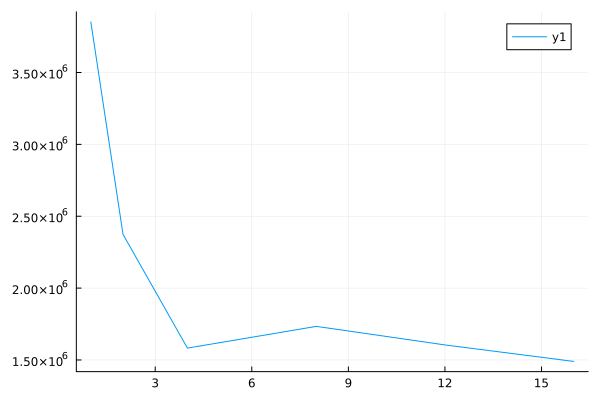

In [9]:
plot([1,2,4,8,12,16], [mean(b1.times), mean(b2.times), mean(b3.times), mean(b4.times), mean(b5.times),mean(b6.times)])

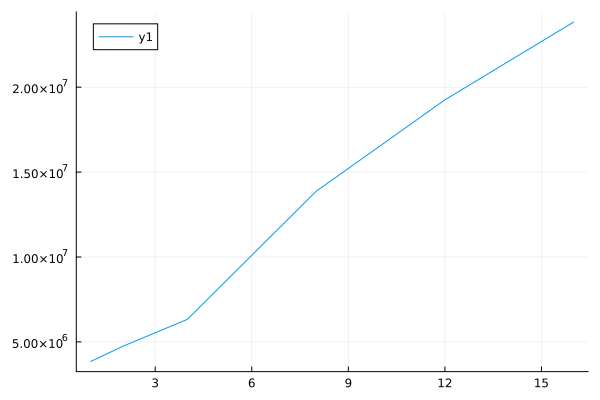

In [10]:
plot([1,2,4,8,12,16], [1*mean(b1.times), 2*mean(b2.times), 4*mean(b3.times), 8*mean(b4.times), 12*mean(b5.times), 16*mean(b6.times)])

Does using single floating precision help?

In [11]:
z = rand(Float32, n_z1_z2, n_k)
y = FFTW.plan_r2r(z, FFTW.DHT, [2])
@benchmark $y*$z

BenchmarkTools.Trial: 4094 samples with 1 evaluation.
 Range (min … max):  807.333 μs …   8.317 ms  ┊ GC (min … max):  0.00% … 85.26%
 Time  (median):     979.792 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.213 ms ± 689.625 μs  ┊ GC (mean ± σ):  16.78% ± 19.39%

  ▃▇█▇▇▅▄▂▁▁                                                    ▁
  ███████████▇▆▇▇▅▆▄▆▄▃▄▅▆▆▆▅▆▆▆▆▅▆▅▇▆▆▇▆▆▆▆█▇▆▇▇▆▇▆▆▅▆▆▆▆▆▅▆▆▅ █
  807 μs        Histogram: log(frequency) by time       3.94 ms <

 Memory estimate: 5.50 MiB, allocs estimate: 111.

Why working with floats would improve performance?

### Benchmark sull'integrale in k interno

Some improvements, but nothing dramatic. So,  next step: matrix multiplication to perform the integrals!

$$
w(\ell, \chi_1, \chi_2)=\sum_{n=0}^{N_\mathrm{max}}c_n(\chi_1, \chi_2)\int d k \,T_n(k) j_{\ell}\left(k \chi_1\right)j_{\ell}\left(k \chi_2\right)
$$
We can define
$$
\hat{T}_n(\ell,\chi_1,\chi_2)\equiv\int d k \,T_n(k) j_{\ell}\left(k \chi_1\right)j_{\ell}\left(k \chi_2\right)
$$
from which follows
$$
w(\ell, \chi_1, \chi_2)=\sum_{n=0}^{N_\mathrm{max}}c_n(\chi_1, \chi_2)\hat{T}_n(\ell,\chi_1,\chi_2)
$$
We can compute this is a tensor contraction

In [12]:
w = zeros(n_l, n_z1, n_z2) #projected matter density 
c = rand(n_z1, n_z2, n_k) # matrice con i coefficienti di Cheb, il terzo indice è il numero di punti in k legato al grado del polinomio
T = rand(n_l, n_z1, n_z2, n_k) #integrali numerici

function w_ell_computation!(w, c, T) #punto esclamativo: void function, non ritorna nulla ma modifica il primo argomento
    @fastmath @inbounds for i ∈ axes(T,1), j ∈ axes(T,2), k ∈ axes(T,3) #baseline version
        Cmn = zero(eltype(c))
        for l ∈ axes(T,4)
            Cmn += c[j,k,l] * T[i,j,k,l]
        end
        w[i,j,k] = Cmn
    end
end

function w_ell_computation_turbo!(w, c, T)
    @turbo for i ∈ axes(T,1), j ∈ axes(T,2), k ∈ axes(T,3) #turbo: macro che ottimizza la performance
        Cmn = zero(eltype(c))
        for l ∈ axes(T,4)
            Cmn += c[j,k,l] * T[i,j,k,l]
        end
        w[i,j,k] = Cmn
    end
end

function w_ell_computation_tturbo!(w, c, T)
    @tturbo for i ∈ axes(T,1), j ∈ axes(T,2), k ∈ axes(T,3) #thread turbo->sfrutto più threads
        Cmn = zero(eltype(c))
        for l ∈ axes(T,4)
            Cmn += c[j,k,l] * T[i,j,k,l]
        end
        w[i,j,k] = Cmn
    end
end

function w_ell_computation_tullio(c, T)
    return @tullio w[i,j,k] := c[j,k,l] * T[i,j,k,l] #pacchetto comodo per authomatic diff. qui non efficientissimo.
end                                                  #fa contrazioni di indici alla einstein

w_ell_computation_tullio (generic function with 1 method)

In [13]:
@benchmark w_ell_computation!(w, c, T)

BenchmarkTools.Trial: 40 samples with 1 evaluation.
 Range (min … max):  120.445 ms … 137.288 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     128.583 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   128.154 ms ±   5.382 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁█▁         ▁      ▁                ▁    ▁ ▁    ▁ ▁            
  ███▁▆▁▁▁▆▁▁▆█▆▁▁▁▁▁█▆▁▆▁▁▆▁▆▁▁▁▆▁▁▁▁█▆▁▁▁█▆█▁▆▆▆█▆█▆▁▆▁▁▁▁▁▁▆ ▁
  120 ms           Histogram: frequency by time          137 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [14]:
@benchmark w_ell_computation_turbo!(w, c, T)

BenchmarkTools.Trial: 505 samples with 1 evaluation.
 Range (min … max):  9.708 ms …  12.221 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.797 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.911 ms ± 304.299 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄█▇▆▄▄▃▃▃▂▁▁ ▁                                               
  ████████████▇█▇▇▄▇▄▅▇▄▆▅▄▅▁▄▅▄▄▄▄▆▄▁▄▁▄▅▄▁▁▁▅▅▄▁▁▁▁▄▁▁▁▄▁▁▅ ▇
  9.71 ms      Histogram: log(frequency) by time      11.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

w è una matrice già allocata, quindi non ha usato memoria nuova

In [15]:
@benchmark w_ell_computation_tturbo!(w, c, T)

BenchmarkTools.Trial: 501 samples with 1 evaluation.
 Range (min … max):  9.794 ms …  12.264 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.882 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.981 ms ± 268.718 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃█▇▃                                                         
  █████▇▆▆▄▄▃▄▅▃▄▄▄▂▃▂▃▃▃▁▂▃▁▂▁▂▃▂▃▁▂▁▂▂▁▁▁▂▁▂▂▁▁▂▃▂▂▁▁▃▁▂▂▁▂ ▃
  9.79 ms         Histogram: frequency by time        11.1 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [16]:
@benchmark w_ell_computation_tullio(c, T)

BenchmarkTools.Trial: 910 samples with 1 evaluation.
 Range (min … max):  4.613 ms … 16.527 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.993 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.482 ms ±  1.431 ms  ┊ GC (mean ± σ):  1.07% ± 5.13%

  ▄█▆▄▅▄▃▃▁▂ ▁                                                
  █████████████▆▇▆▄▅▅▅▅▅▄▄▄▁▁▅▄▄▄▄▅▅▄▆▄▅▁▄▁▁▄▄▄▁▁▁▁▄▁▄▁▁▁▁▄▄ █
  4.61 ms      Histogram: log(frequency) by time     13.3 ms <

 Memory estimate: 1.55 MiB, allocs estimate: 109.

Nice! We now need to do the final integration! Again, this is cast as a tensor contraction

### Benchmark for $\chi_{1,2}$ integrals

In [17]:
w = rand(n_l, n_z1, n_z2) 
WA = rand(n_tomo1, n_z1) #window functions
WB = rand(n_tomo2, n_z2)
c = rand(n_z1, n_z2, n_k) 
T = rand(n_l, n_z1, n_z2, n_k)
Cℓ = zeros(n_l, n_tomo1, n_tomo2) #C_l computation

function C_ell_computation!(Cℓ, w, WA, WB)
    for i ∈ axes(w,1), j ∈ axes(WA,1), k ∈ axes(WB,1)
        Cmn = zero(eltype(w))
        for l ∈ axes(WA,2)
            for m ∈ axes(WB,2)
                Cmn += w[i,l,m]*WA[j,l]*WB[k,m]
            end
        end
        Cℓ[i,j,k] = Cmn
    end
end

function C_ell_computation_turbo!(Cℓ, w, WA, WB)
    @turbo for i ∈ axes(w,1), j ∈ axes(WA,1), k ∈ axes(WB,1)
        Cmn = zero(eltype(w))
        for l ∈ axes(WA,2)
            for m ∈ axes(WB,2)
                Cmn += w[i,l,m]*WA[j,l]*WB[k,m]
            end
        end
        Cℓ[i,j,k] = Cmn
    end
end

function C_ell_computation_tturbo!(Cℓ, w, WA, WB)
    @tturbo for i ∈ axes(w,1), j ∈ axes(WA,1), k ∈ axes(WB,1)
        Cmn = zero(eltype(w))
        for l ∈ axes(WA,2)
            for m ∈ axes(WB,2)
                Cmn += w[i,l,m]*WA[j,l]*WB[k,m]
            end
        end
        Cℓ[i,j,k] = Cmn
    end
end

function C_ell_computation_tullio(w, WA, WB)
    @tullio Cℓ[i,j,k] := w[i,l,m]*WA[j,l]*WB[k,m]
end

C_ell_computation_tullio (generic function with 1 method)

In [18]:
@benchmark C_ell_computation!(Cℓ, w, WA, WB)

BenchmarkTools.Trial: 512 samples with 1 evaluation.
 Range (min … max):  9.634 ms … 10.069 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.792 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.772 ms ± 85.493 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅▅▃▃▁▁                █▇▆▄▄▄▂                               
  ████████▇█▁▅▄▅▅▅▄▅▄▅▄▆██████████▇▁▄▁▅▄▁▄▅▄▄█▆▅▅▅▄▁▁▄▁▄▅▄▁▄ █
  9.63 ms      Histogram: log(frequency) by time       10 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [19]:
@benchmark C_ell_computation_turbo!(Cℓ, w, WA, WB)

BenchmarkTools.Trial: 6150 samples with 1 evaluation.
 Range (min … max):  802.791 μs … 938.959 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     807.208 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   812.045 μs ±  11.060 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▆▄▅▆▂▄▁ ▂▂▁▁▁  ▃▇▅▃▄▄▂▂▂▁▁  ▁                          ▁▁    ▂
  ██████████████▇▆███████████████████▇▇▇▇▇▆▅▅▅▆▅▆▅▅▆▃▇▅▆▁▅███▇▇ █
  803 μs        Histogram: log(frequency) by time        850 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [20]:
@benchmark C_ell_computation_tturbo!(Cℓ, w, WA, WB)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  259.500 μs … 782.667 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     275.625 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   279.836 μs ±  14.816 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄▁               ▁▁▄█▅▂▄▃▄▁▄▃▃▁▂▃▁▂▁        ▂▄▁   ▁  ▁      ▂ ▁
  ██▆▆█▄▅▄▃▄▃▅▇▇█▆▇████████████████████▆▇▆▆▆▅▆███▇███▆▇█▇▆█▇▇▆█ █
  260 μs        Histogram: log(frequency) by time        307 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
@benchmark C_ell_computation_tullio(w, WA, WB)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  287.084 μs …  10.736 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     367.875 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   415.735 μs ± 523.340 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

            ▄█▃▃█▃                                               
  ▁▁▂▂▃▄▅▇▇▇██████▆▅▆▅▄▄▃▃▃▃▂▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  287 μs           Histogram: frequency by time          634 μs <

 Memory estimate: 13.78 KiB, allocs estimate: 108.

In [37]:
x = chebpoints(100, 2, 3000) # 100: punti da considerare 2:inizio int e fine int dei multipoli 
ℓ = reverse(x[findall(<(300), x)])#prendo solo punti con l<230 dall'array x 
b = append!(ℓ, [20., 50., 100., 200., 300.])

26-element Vector{Float64}:
   2.0
   2.739666011768332
   4.957934086020933
   8.652615059983086
  13.820062729597831
  20.455177447888648
  28.551411157695608
  38.10077385381776
  49.093841468182184
  61.51976517026251
  75.36628207356486
  90.61972733761604
 107.26504765351123
 125.2858160997126
 144.664248353437
 165.3812202416367
 187.4162866142485
 210.74770152108832
 235.35243967247973
 261.206219162432
 288.28352543195393
  20.0
  50.0
 100.0
 200.0
 300.0

In [38]:
using NPZ
#b = reverse(x[findall(<(300), x)])+[20, 50, 100, 200, 300]
npzwrite("ell_vector.npy", b)

In [39]:
npzread("ell_vector.npy")

26-element Vector{Float64}:
   2.0
   2.739666011768332
   4.957934086020933
   8.652615059983086
  13.820062729597831
  20.455177447888648
  28.551411157695608
  38.10077385381776
  49.093841468182184
  61.51976517026251
  75.36628207356486
  90.61972733761604
 107.26504765351123
 125.2858160997126
 144.664248353437
 165.3812202416367
 187.4162866142485
 210.74770152108832
 235.35243967247973
 261.206219162432
 288.28352543195393
  20.0
  50.0
 100.0
 200.0
 300.0

100 nodi di cheb da 2 e 3000-> solo 18 sono sotto 230. 

In [22]:
? chebpoints

search: chebpoints



```
chebpoints(order, lb, ub)
```

Return an array of Chebyshev points (as `SVector` values) for the given `order` (an array or tuple of polynomial degrees), and hypercube lower-and upper-bound vectors `lb` and `ub`. If `ub` and `lb` are numbers, returns an array of numbers.

These are the points where you should evaluate a function in order to create a Chebyshev interpolant with `chebinterp`.

(Note that the number of points along each dimension is `1 +` the order in that direction.)


In [ ]:
ℓ